In [1]:
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from math import sqrt


In [2]:
links = []
list_html = []
list_html0 = []
carname = []
listing_data = []
prices = []


for page in range(1,100,1):
    url = f'https://www.autouncle.dk/da/brugte-biler/f-benzin?page={page}&search_form=1'
    links.append(url)
    
for url in links:
    response = requests.get(url, headers={'email':'ptj867@alumni.ku.dk', 'Purpose':'For exam project'})
    time.sleep(2)
    list_html.append(response)

for url0 in list_html:
    soup = BeautifulSoup(url0.content, 'lxml')
    list_html0.append(soup)
    
for element in list_html0:
    inner_rows = element.find_all('a', class_='listing-item-headline truncated')
    carname.append(inner_rows)

flat_list = [item for sublist in carname for item in sublist]
carname_df = pd.DataFrame(flat_list)


for data in list_html0:
    inner_rows1 = data.find_all('div', class_='listing-item-info-chip')
    listing_data+=inner_rows1

Year = [
    [div_element for div_element in inner_list if re.search(r"\d{4}", div_element.get_text())]
    for inner_list in listing_data
]

KM = [
    [div_element for div_element in inner_list if "km" in div_element.get_text()]
    for inner_list in listing_data
]
Motor = [
    [div_element for div_element in inner_list if "Benzin" in div_element.get_text()]
    for inner_list in listing_data
]
Gear = [
    [div_element for div_element in inner_list if "gear" in div_element.get_text()]
    for inner_list in listing_data
]
HK = [
    [div_element for div_element in inner_list if "HK" in div_element.get_text()]
    for inner_list in listing_data
]
df = pd.DataFrame({'Year':Year,'KM':KM, 'Motor':Motor, 'Gear':Gear, 'HK':HK})
df = df[df.applymap(lambda x: x != []).any(axis=1)]
df['Year'] = df['Year'].shift(4)
df['KM'] = df['KM'].shift(3)
df['Motor'] = df['Motor'].shift(2)
df['Gear'] = df['Gear'].shift(1)
df = df.applymap(lambda x: [] if 'CO2' in str(x) else x)
df = df.applymap(lambda x: [] if x is None else x)
df = df[df.applymap(lambda x: x != []).any(axis=1)]
df.reset_index(inplace=True)


for price in list_html0:    
    inner_rows2 = price.find_all('div', class_='listing-item-price')
    prices+= inner_rows2  # Append the text, not the element itself
pricesdf = pd.DataFrame({'Price': prices})
pricesdf

def extract_numeric_value(cell):
    match = re.search(r'\d+\.\d+', cell)
    if match:
        return match.group()
    else:
        return None

cleaned_prices = pricesdf.applymap(lambda cell: extract_numeric_value(str(cell)))

final_data = pd.concat([carname_df, cleaned_prices, df], axis=1)
final_data = final_data.drop(columns=['index'])

columns = ['Title','Price (DKK)', 'Year', 'KM driven', 'Motor (Litres)', 'Manual/Automatic gear', 'Horsepower']
final_data.columns=columns


In [3]:
#Removing brackets and quotations marks from all cells
for col in columns:
    final_data[col] = final_data[col].astype(str).str.replace(r'\[|\]','', regex=True).str.replace(r'\'|\'','', regex=True)

#Cleaning up the dataset, converting integers, strings etc.  
final_data['KM driven'] = final_data['KM driven'].str.replace(' km', '').str.replace('.', '').astype(int)
final_data['Motor (Litres)'] = final_data['Motor (Litres)'].str.replace('L Benzin', '').astype(float)
final_data['Price (DKK)']= final_data['Price (DKK)'].str.replace('.', '').astype(int)

#Cleansing the Horsepower column for letters, such it can be converted to an interger
final_data['Horsepower'] = final_data['Horsepower'].str.replace(r'\(.*\)', '', regex=True).str.replace(r'\D', '', regex=True).str.strip()
final_data = final_data[final_data['Horsepower'] != '']
final_data['Horsepower'] = final_data['Horsepower'].astype(int)

#Removing months from the year column
final_data['Year'] = final_data['Year'].str.replace(r'\D', '', regex=True).astype(int)

#Creating new 'Car Manufacturer' column by extracting the first word of the 'Title'column.
final_data['Car Manufacturer'] = final_data['Title'].str.split().str[0].astype(str)

#Cleaning the 'Title' column
final_data['Title'] = final_data['Title'].str.rstrip('aut. \n')

final_data

/var/folders/x2/pd2_0wnx52bb474g018r9ns00000gn/T/ipykernel_32741/2635147196.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data['KM driven'] = final_data['KM driven'].str.replace(' km', '').str.replace('.', '').astype(int)
/var/folders/x2/pd2_0wnx52bb474g018r9ns00000gn/T/ipykernel_32741/2635147196.py:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  final_data['Price (DKK)']= final_data['Price (DKK)'].str.replace('.', '').astype(int)


,Title,Price (DKK),Year,KM driven,Motor (Litres),Manual/Automatic gear,Horsepower,Car Manufacturer
0,"Mercedes GLA200 1,3 Advantage",479900,2022,14000,1.3,Manuelt gear,163,Mercedes
1,"Mercedes C300 2,0 AMG Line",589900,2022,14000,2.0,Manuelt gear,258,Mercedes
2,"Mercedes A200 1,3 Advantage AMG",389900,2023,12000,1.3,Automatgear,163,Mercedes
3,"Mercedes A200 1,3 AMG Line",344900,2020,39000,1.3,Automatgear,163,Mercedes
4,"Mercedes GLA200 1,3 Advantage",469900,2022,21000,1.3,Automatgear,163,Mercedes
...,...,...,...,...,...,...,...,...
2371,"Kia Picanto 1,0 MPI Attraction Collection 67HK...",94800,2018,58000,1.0,Manuelt gear,67,Kia
2372,"Ford Puma 1,0 EcoBoost mHEV Titanium",267500,2022,100,1.0,Manuelt gear,125,Ford
2373,"Ford Puma 1,0 EcoBoost mHEV ST-Line",287000,2023,1000,1.0,Manuelt gear,155,Ford
2374,"VW Golf VII 1,5 TSi 130 Comfortline Variant DSG",228900,2018,72600,1.5,Automatgear,130,VW


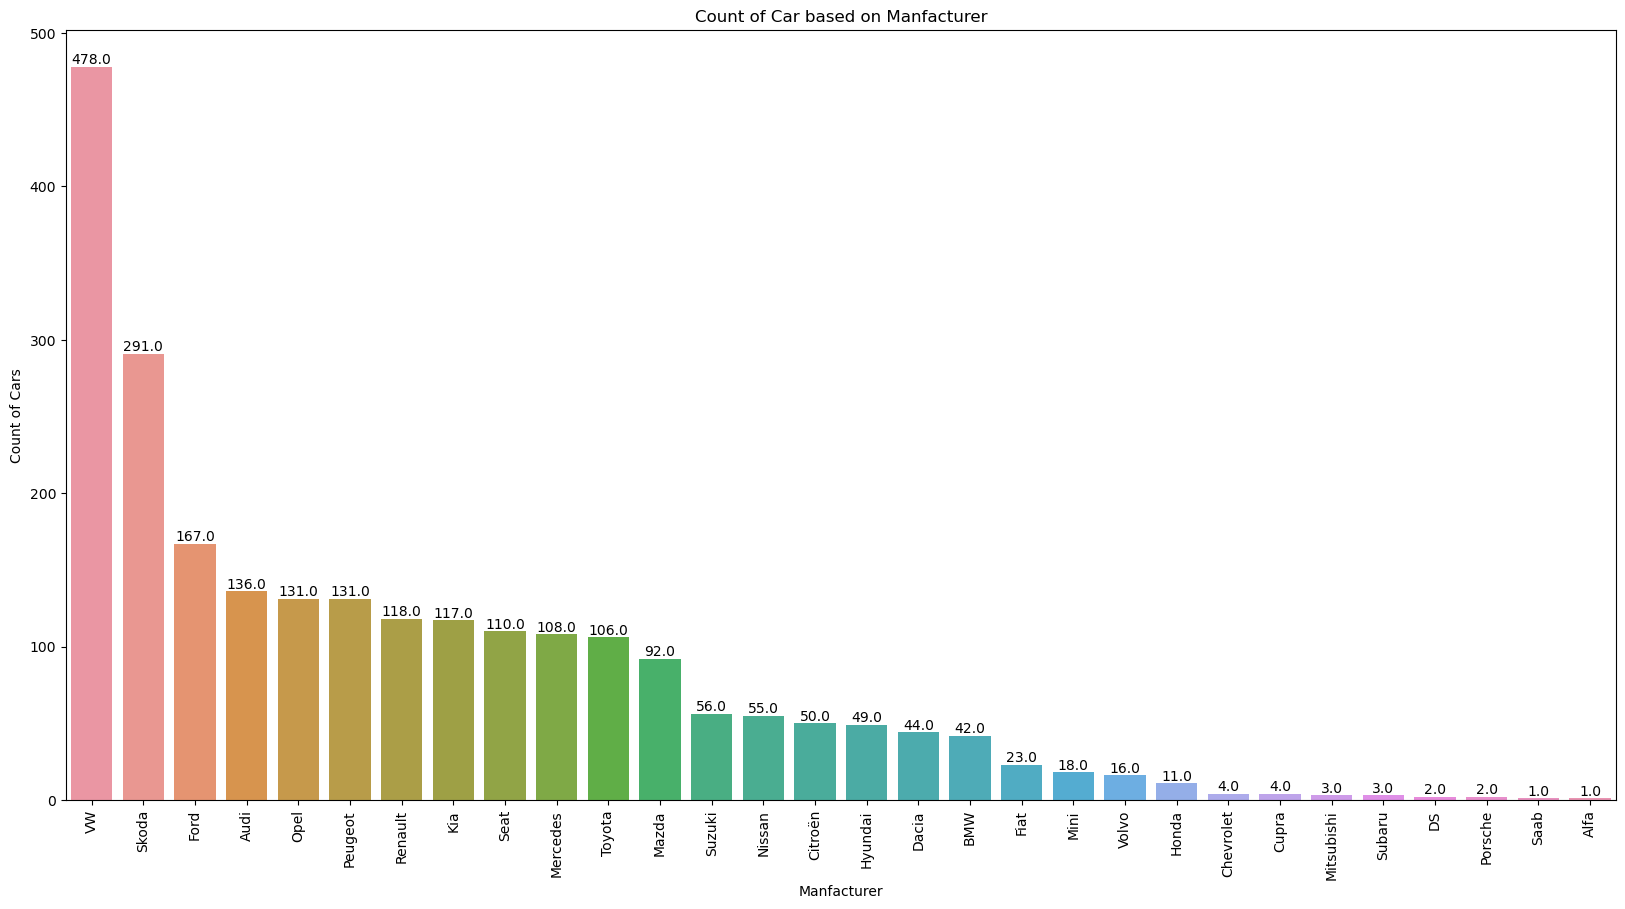

In [4]:
plt.rcParams['figure.figsize'] = 20,10
Cars = final_data['Car Manufacturer'].value_counts()
plot = sns.barplot(x = Cars.index,y = Cars.values,data = df)
plt.xticks(rotation = 90)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2.0,p.get_height()),
                 ha = 'center',va = 'center',xytext = (0,5),textcoords = 'offset points')
plt.title('Count of Car based on Manfacturer')
plt.xlabel('Manfacturer')
plt.ylabel('Count of Cars')
plt.savefig('Count of Cars.png')
plt.show()

/var/folders/x2/pd2_0wnx52bb474g018r9ns00000gn/T/ipykernel_32741/1318318993.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(final_data.corr(),cmap = sns.cubehelix_palette(as_cmap = True),annot = True, cbar = True,square = True)


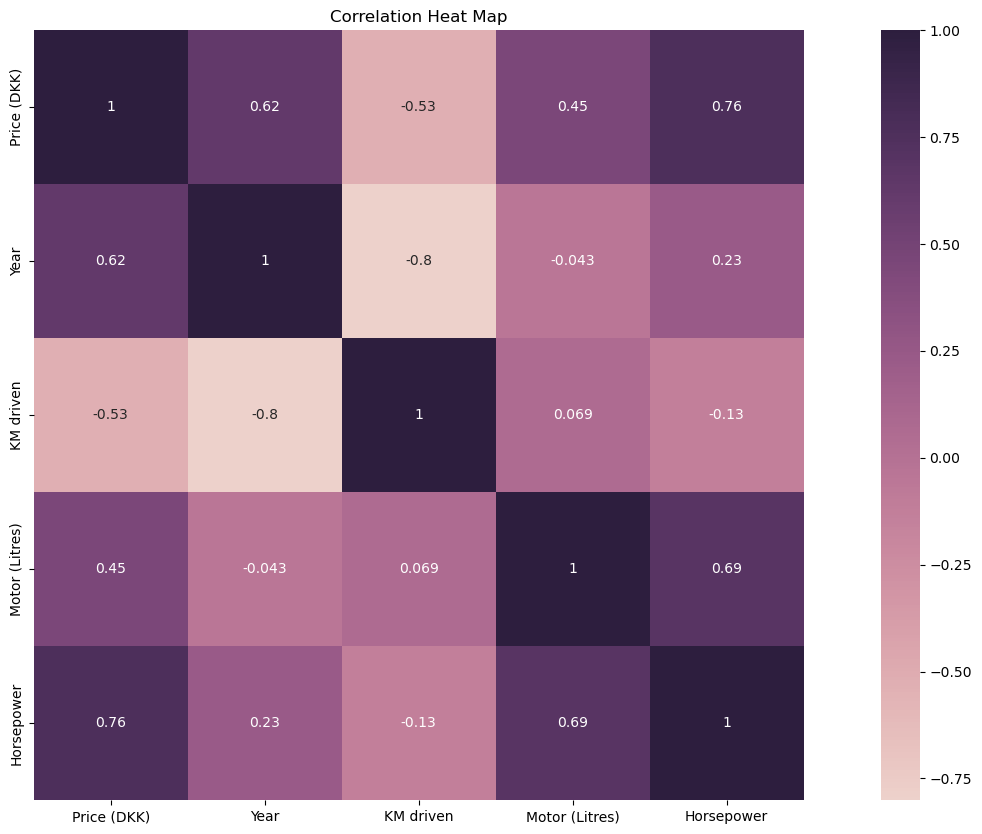

In [39]:
sns.heatmap(final_data.corr(),cmap = sns.cubehelix_palette(as_cmap = True),annot = True, cbar = True,square = True)
plt.title('Correlation Heat Map')
plt.savefig('Correlation Heat Map.png')
plt.show()

AttributeError: module 'seaborn' has no attribute 'legend'

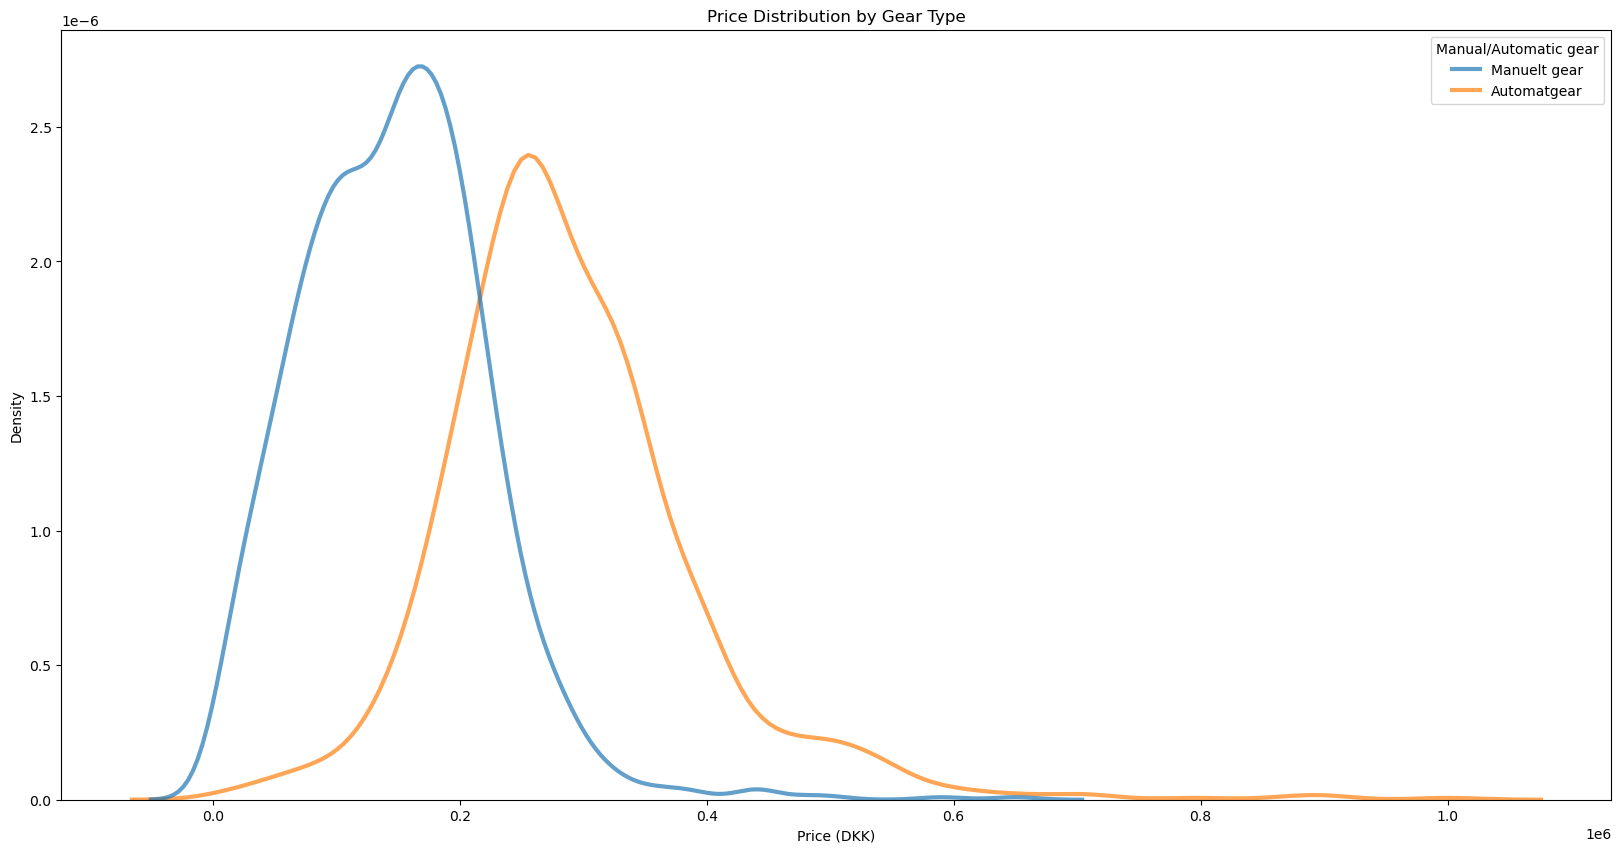

In [6]:
sns.kdeplot(data=final_data, x="Price (DKK)", hue="Manual/Automatic gear", multiple="layer", linewidth=3, alpha=0.7)
plt.title("Price Distribution by Gear Type")
plt.xlabel("Price (DKK)")
plt.ylabel("Density")

# Add legend
sns.legend(title="Gear Type")

# Show the plot
plt.show()


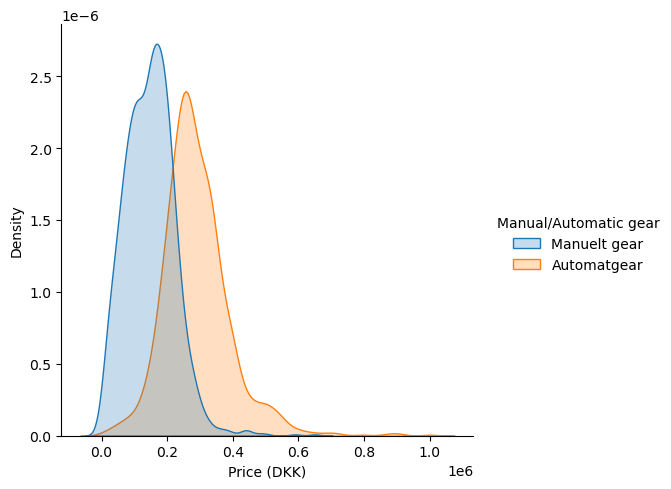

In [7]:
sns.displot(data=final_data, x="Price (DKK)", hue="Manual/Automatic gear", kind="kde", fill=True)


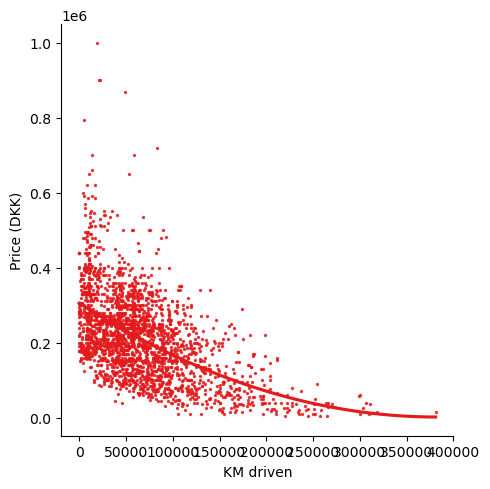

In [12]:
sns.lmplot(x="KM driven", y="Price (DKK)", data=final_data,
           order=2, ci=None, scatter_kws={"s": 2});

<Axes: xlabel='Price (DKK)', ylabel='KM driven'>

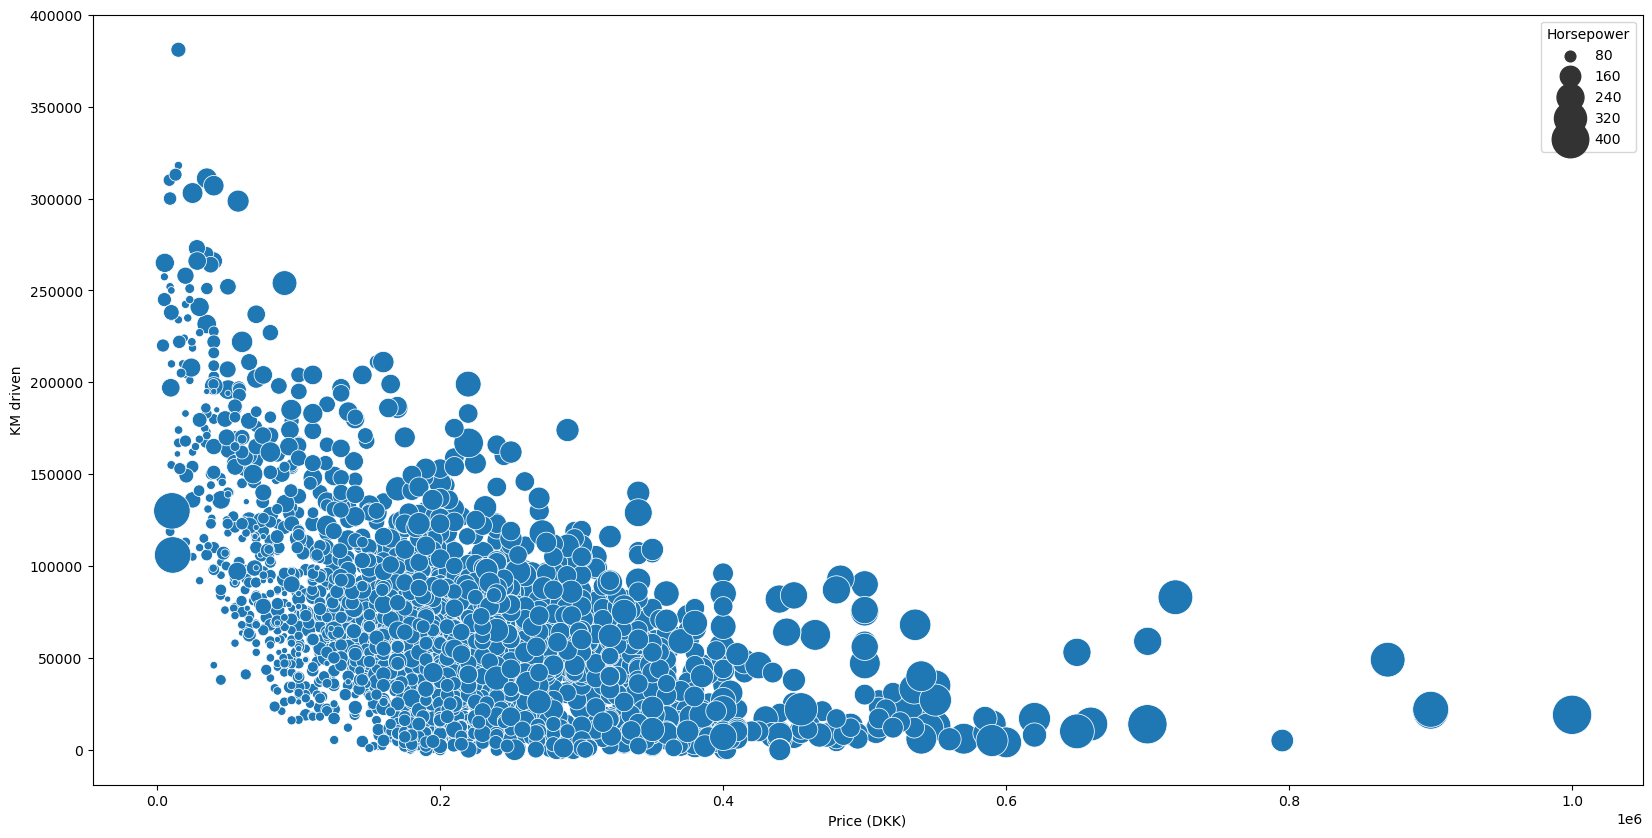

In [9]:
sns.scatterplot(
    data=final_data, x="Price (DKK)", y="KM driven", size="Horsepower",
    sizes=(20, 800)
)



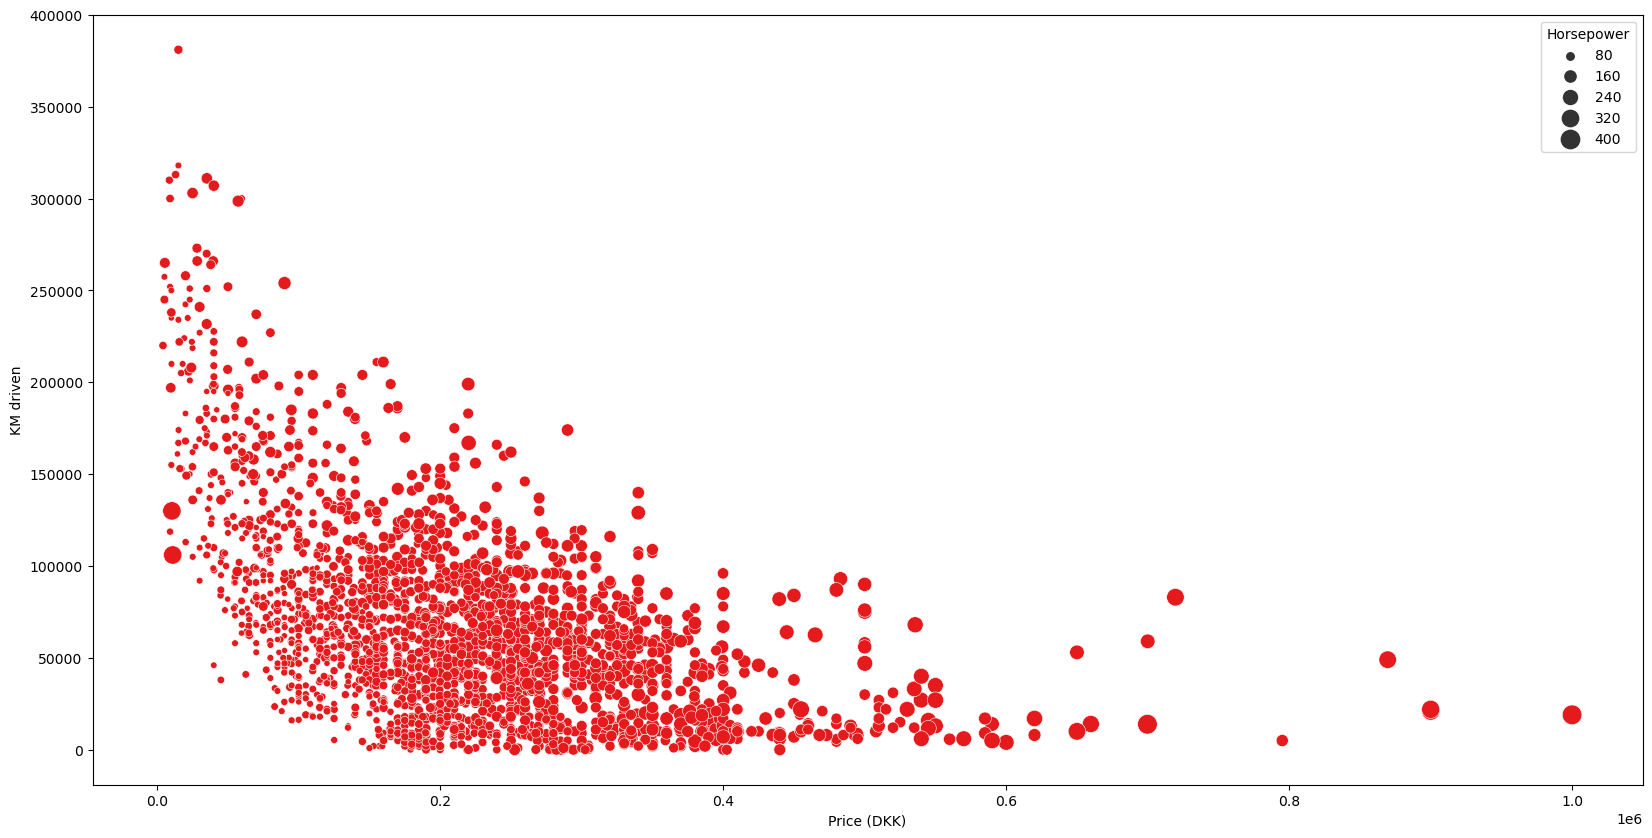

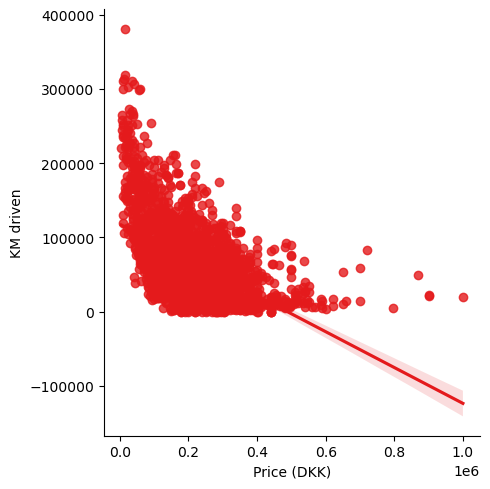

In [10]:
sns.set_palette("Set1")

# Create the scatter plot
scatter_plot = sns.scatterplot(
    data=final_data, x="Price (DKK)", y="KM driven",
    size="Horsepower",
    sizes=(20, 200)
)
sns.lmplot(data=final_data, x="Price (DKK)", y="KM driven")


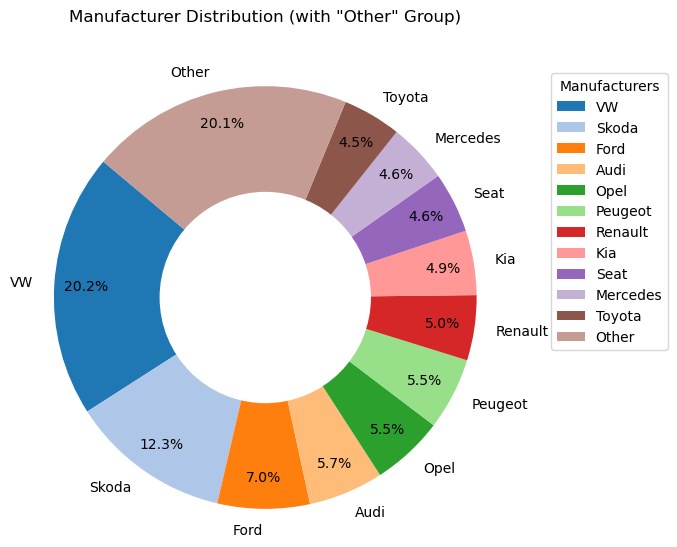

In [31]:
colors = sns.color_palette('pastel')

#create pie chart
manufacturer_counts = final_data['Car Manufacturer'].value_counts()

threshold = 100

# Find groups with counts below the threshold
small_groups = manufacturer_counts[manufacturer_counts < threshold]

# Replace small groups with 'Other'
manufacturer_counts['Other'] = small_groups.sum()
manufacturer_counts.drop(small_groups.index, inplace=True)

colors = plt.cm.tab20.colors

# Plot a pie chart
plt.figure(figsize=(6, 6))
plt.pie(manufacturer_counts, labels=manufacturer_counts.index, autopct='%1.1f%%', startangle=140,
        colors=colors, shadow=False, pctdistance=0.85)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Manufacturer Distribution (with "Other" Group)',y=1.08)
plt.legend(title='Manufacturers', loc='upper left', bbox_to_anchor=(1.1, 1))
centre_circle = plt.Circle((0,0),0.5,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.show()

In [40]:
final_data.to_csv('EndeligData.csv', index=True)